In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
plt.rcParams['font.sans-serif'] = ['SimHei']

## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_19140\2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0018'][0]), len(Battery['B0018'][1])

(132, 132)

## 画出数据

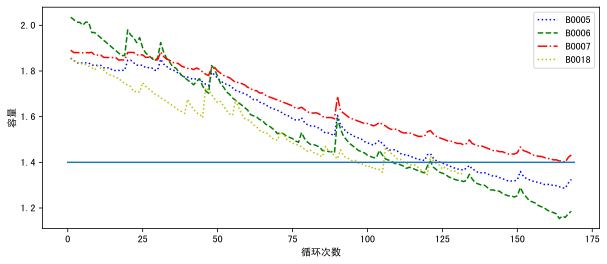

In [4]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

## 构建训练序列数据

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        # target = text[i + window_size] # y 只有一列
        target = text[i + 1:i + 1 + window_size] # y 有 window_size 列
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v[1], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 创建评估指标函数

In [6]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 随机种子

In [19]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [7]:
# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for X, Y in train_iter:
        print(X.shape)
        print(Y.shape)
        print(X[1])
        print(Y[1])
        print('Y[:, -1]', Y[:, -1].reshape(-1, 1).shape)
        # break

    print(torch.from_numpy(np.array(Battery['B0006'][1][1:18])))

train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[0], window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 420, is_train=False)
validate_train_iter(train_iter)
len(train_x)

torch.Size([420, 16])
torch.Size([420, 16])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783])
tensor([2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
        1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676])
Y[:, -1] torch.Size([420, 1])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676],
       dtype=torch.float64)


420

## 层规范化

In [8]:
# 层规范化
# 假设此时输入的数据维度是[3, 4]，则对3个长度为4的向量求均值方差，得到3个均值和3个方差
# 分别对这3行进行归一化（每一行的4个数字都是均值为0，方差为1） 
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 前馈网络层

In [9]:
# 前馈网络层
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

## 注意力机制块

In [10]:
# 注意力机制块
class AttentionBlock(nn.Module):
    """注意力机制块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads,
                 norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        
        # 多头注意力层
        # nn.MultiheadAttention(embed_dim=16,num_heads=4,kdim=16,vdim=1,batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=query_size, num_heads=num_heads, kdim=key_size, vdim=value_size, batch_first=True)
        
        # 层规范化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        # 前馈网络层
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        
        # 层规范化
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, Y):
        batch_size, seq_len, feature_size = X.shape
        Value = Y[:, :, -1].reshape(batch_size, seq_len, -1)
        # print('Value.shape', Value.shape)
        
        
        # attention 的输出 shape: (batch_size, 1, window_size)
        attn_output, _ = self.attention(X, Y, Value)
        # addnorm1 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm1(X, attn_output)
        
        # ffn 的输出 shape: (batch_size, 1, window_size)
        # addnorm2 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm2(X, self.ffn(X))
        
        return X
    

# 测试 输出形状
atten = AttentionBlock(16, 16, 1, 16, 4, [1, 16], 16, 32, 0.5, False)
X = torch.rand(420, 1, 16)
Y = torch.rand(420, 1, 16)
out = atten(X, Y)
out.shape

torch.Size([420, 1, 16])

## 3维数据的残差网络

In [11]:
# 残差网络
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        Y += X
        return F.relu(Y)

# blk = Residual(3,3)
# X = torch.rand(4, 3, 6, 6)
blk = Residual(1, 8)
X = torch.rand(30, 1, 4, 4)
Y = blk(X)
Y.shape

torch.Size([30, 8, 4, 4])

## 搭建模型

In [12]:
# 模型
class Net(nn.Module):
    def __init__(self, embed_size, window_size, 
                 key_size, query_size, value_size, num_hiddens, num_heads, dropout,
                 norm_shape, 
                 ffn_num_input, ffn_num_hiddens, 
                 num_layers,
                 input_channels=1, num_channels=8,
                 n_class=1, use_bias=False):
        super(Net, self).__init__()
        
        # 嵌入层来自于nlp，但是不知道是否适用于容量时序数据
        # 嵌入层只使用整型数据，容量数据是浮点型数据，不适用嵌入层
        # self.embedding = nn.Embedding(vocab_size, embed_size) # 嵌入层
        
        # 用线性层扩展维度来代替 nn.Embedding
        # self.embedding = nn.Linear(1, embed_size)
        
        # 位置嵌入是可学习的，因此创建一个足够长的位置嵌入参数，该方法来自于bert
        # bert模型大，训练数据集也够大，所以使用可学习的位置嵌入
        # 锂电池容量数据集不大，不一定适合可学习的位置嵌入
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, window_size)) # torch.randn 满足标准正态分布
        
        # 多头注意力块
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                AttentionBlock(key_size, query_size, value_size, num_hiddens, num_heads,
                             norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias))
        
        # 卷积残差网络层
        self.residual = Residual(input_channels, num_channels)
        
        # 输出层
        self.outLinear = nn.Linear(window_size, n_class)

    def forward(self, X, Y): # 输入 X和Y 的形状都是 (batch_size, window_size)
        X = X.unsqueeze(1) # 输出 X shape: (batch_size, 1, window_size)
        Y = Y.unsqueeze(1) # 输出 Y shape: (batch_size, 1, window_size)
        
        X = X + self.pos_embedding.data # X shape: (batch_size, 1, window_size),这里使用的广播机制
        
        
        for i, blk in enumerate(self.blks):
            X = blk(X, Y) # 最终 X shape: (batch_size, 1, window_size)
        
        batch_size, seq_len, feature_size = X.shape
        # X = self.residual(X.reshape(batch_size, seq_len, 4, 4))
        
        X = self.outLinear(X.reshape(batch_size, -1))
        
        return X

## 测试模型的输出

In [13]:
# 测试模型的输出
X = torch.zeros((420, 16))
Y = torch.zeros((420, 16))
net = Net(8, 16, 
          16, 16, 1, 16, 4, 0.1, 
          [1, 16], 
          16, 32,
          2)
output = net(X, Y)
output.shape

torch.Size([420, 1])

## 一个批次的训练函数

In [14]:
def train_epoch(net, train_iter, loss, updater, feature_size, Rated_Capacity): 
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for X, Y in train_iter:
        # 计算梯度并更新参数
        # X = torch.reshape(X / Rated_Capacity, (-1, 1, feature_size)).type(torch.float32)
        X = (X / Rated_Capacity).type(torch.float32)
        # Y = torch.reshape(Y / Rated_Capacity, (-1, 1)).type(torch.float32)
        Y = (Y / Rated_Capacity).type(torch.float32)
        X, Y = X.to(device), Y.to(device)
        
        # y_hat = net(X, Y)
        y_hat = net(X, X)
        l = loss(y_hat, Y[:, -1].reshape(-1, 1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [28]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 100 == 0:
            pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity)
            # print('pre_list', pre_list)
            mae, rmse = evaluation(test_data, pre_list)
            re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
            print('epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(epoch, train_loss, mae, rmse, re))
            
            if (train_loss < 0.0002) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
                break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

## 预测函数

In [16]:
def predict(net, train_data, test_data, feature_size, Rated_Capacity):
    test_x = train_data.copy()
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        # x = np.reshape(np.array(test_x[-feature_size:]) / Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
        x = (np.array(test_x[-feature_size:]) / Rated_Capacity).astype(np.float32)
        x = torch.from_numpy(x).reshape(-1, feature_size).to(device)  # shape: (batch_size, input_size)
        pred = net(x, x).cpu()
        # print('pred.shape', pred.shape)
        next_point = pred.data.numpy()[0, 0] * Rated_Capacity
        # print('next_point', next_point)
        test_x.append(next_point)  # 测试值加入原来序列用来继续预测下一个点
        point_list.append(next_point)  # 保存输出序列最后一个点的预测值
    return point_list

## 开始训练

In [25]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
batch_size = 30
lr = 0.0005
weight_decay = 0.0
num_epochs = 4000
window_size = 16
embed_size = 8 # 每一个容量数据以8个特征来表示

key_size, query_size, value_size, num_hiddens = 16, 16, 1, 16
num_heads, dropout = 4, 0.1
norm_shape = [1, 16]
ffn_num_input, ffn_num_hiddens = 16, 64
num_layers = 4

setup_seed(0)

# 获取数据集，生成train_iter
# 使用留一评估
mae_s, rmse_s, re_s = [], [], []
for i in range(4):
    train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
    
    batch_size = len(train_x)
    
    train_x = torch.from_numpy(train_x.astype(np.float32))
    train_y = torch.from_numpy(train_y.astype(np.float32))
    
    train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=False)
    
    # 拿到 vocab_size
    # vocab_size = get_vocab_size(i, window_size)
    
    # 模型、损失函数、优化器
    net = Net(embed_size, window_size, 
              key_size, query_size, value_size, num_hiddens, 
              num_heads, dropout,
              norm_shape, 
              ffn_num_input, ffn_num_hiddens, 
              num_layers)
    loss = nn.MSELoss()
    updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    # 开始训练
    print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
    mae, rmse, re = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae_s.append(mae)
    rmse_s.append(rmse)
    re_s.append(re)

print('---------------------------------')
print('re_s', re_s)
print('---------------------------------')
print(f're mean: {np.array(re_s).mean()}')
print(f'mae mean: {np.array(mae_s).mean()}')
print(f'rmse mean: {np.array(rmse_s).mean()}')
print('---------------------------------')

以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0108756116 , MAE:0.1527 , RMSE:0.1841 , RE:0.3945
epoch:199  , loss:0.0057844883 , MAE:0.1716 , RMSE:0.2011 , RE:0.6697
epoch:299  , loss:0.0038004131 , MAE:0.1677 , RMSE:0.1967 , RE:0.2569
epoch:399  , loss:0.0027873034 , MAE:0.1425 , RMSE:0.1693 , RE:0.3761
epoch:499  , loss:0.0020930448 , MAE:0.1128 , RMSE:0.1363 , RE:0.3211
epoch:599  , loss:0.0015914264 , MAE:0.1393 , RMSE:0.1663 , RE:0.7890
epoch:699  , loss:0.0011148128 , MAE:0.0851 , RMSE:0.1064 , RE:0.4128
epoch:799  , loss:0.0010160806 , MAE:0.1049 , RMSE:0.1243 , RE:0.2202
epoch:899  , loss:0.0009026295 , MAE:0.1220 , RMSE:0.1420 , RE:0.2018
epoch:999  , loss:0.0008833011 , MAE:0.0887 , RMSE:0.1089 , RE:0.0459
epoch:1099 , loss:0.0006573554 , MAE:0.0970 , RMSE:0.1178 , RE:0.1284
epoch:1199 , loss:0.0005574871 , MAE:0.0945 , RMSE:0.1070 , RE:0.3945
epoch:1299 , loss:0.0004640840 , MAE:0.0827 , RMSE:0.0972 , RE:0.1101
epoch:1399 , loss:0.0004547942 , MAE:0.0667 , RMSE:0.0797 , RE:0

epoch:3699 , loss:0.0001562447 , MAE:0.0476 , RMSE:0.0518 , RE:0.1776
epoch:3799 , loss:0.0001565984 , MAE:0.3322 , RMSE:0.3540 , RE:0.6645
epoch:3899 , loss:0.0001711838 , MAE:0.2742 , RMSE:0.3124 , RE:0.0000
epoch:3999 , loss:0.0001382932 , MAE:0.2202 , RMSE:0.2596 , RE:0.0000
以电池 B0018 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0045494167 , MAE:0.1535 , RMSE:0.1865 , RE:0.6296
epoch:199  , loss:0.0013950912 , MAE:0.1823 , RMSE:0.2421 , RE:0.4321
epoch:299  , loss:0.0009133804 , MAE:0.2097 , RMSE:0.2625 , RE:0.7654
epoch:399  , loss:0.0006763567 , MAE:0.1407 , RMSE:0.1711 , RE:0.8642
epoch:499  , loss:0.0005494070 , MAE:0.2237 , RMSE:0.2699 , RE:0.4321
epoch:599  , loss:0.0004051434 , MAE:0.1212 , RMSE:0.1655 , RE:0.1481
epoch:699  , loss:0.0003168239 , MAE:0.2658 , RMSE:0.3127 , RE:0.4321
epoch:799  , loss:0.0002741319 , MAE:0.2071 , RMSE:0.2631 , RE:0.4321
epoch:899  , loss:0.0002498869 , MAE:0.1530 , RMSE:0.1797 , RE:0.4321
epoch:999  , loss:0.0002587536 , MAE:0.2839 , RMSE:0.3182 , RE:0

## 使用seed 值为0-9 训练数据，以能复现

In [26]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
batch_size = 30
lr = 0.0005
weight_decay = 0.0
num_epochs = 4000
window_size = 16
embed_size = 8 # 每一个容量数据以8个特征来表示

key_size, query_size, value_size, num_hiddens = 16, 16, 1, 16
num_heads, dropout = 4, 0.1
norm_shape = [1, 16]
ffn_num_input, ffn_num_hiddens = 16, 64
num_layers = 4


# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('***********************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s = [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)

        batch_size = len(train_x)

        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))

        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=False)

        # 拿到 vocab_size
        # vocab_size = get_vocab_size(i, window_size)

        # 模型、损失函数、优化器
        net = Net(embed_size, window_size, 
                  key_size, query_size, value_size, num_hiddens, 
                  num_heads, dropout,
                  norm_shape, 
                  ffn_num_input, ffn_num_hiddens, 
                  num_layers)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print('---------------------------------')

***********************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0108756116 , MAE:0.1527 , RMSE:0.1841 , RE:0.3945
epoch:199  , loss:0.0057844883 , MAE:0.1716 , RMSE:0.2011 , RE:0.6697
epoch:299  , loss:0.0038004131 , MAE:0.1677 , RMSE:0.1967 , RE:0.2569
epoch:399  , loss:0.0027873034 , MAE:0.1425 , RMSE:0.1693 , RE:0.3761
epoch:499  , loss:0.0020930448 , MAE:0.1128 , RMSE:0.1363 , RE:0.3211
epoch:599  , loss:0.0015914264 , MAE:0.1393 , RMSE:0.1663 , RE:0.7890
epoch:699  , loss:0.0011148128 , MAE:0.0851 , RMSE:0.1064 , RE:0.4128
epoch:799  , loss:0.0010160806 , MAE:0.1049 , RMSE:0.1243 , RE:0.2202
epoch:899  , loss:0.0009026295 , MAE:0.1220 , RMSE:0.1420 , RE:0.2018
epoch:999  , loss:0.0008833011 , MAE:0.0887 , RMSE:0.1089 , RE:0.0459
epoch:1099 , loss:0.0006573554 , MAE:0.0970 , RMSE:0.1178 , RE:0.1284
epoch:1199 , loss:0.0005574871 , MAE:0.0945 , RMSE:0.1070 , RE:0.3945
epoch:1299 , loss:0.0004640840 , MAE:

epoch:3599 , loss:0.0001400835 , MAE:0.0730 , RMSE:0.0775 , RE:0.2105
epoch:3699 , loss:0.0001562447 , MAE:0.0476 , RMSE:0.0518 , RE:0.1776
epoch:3799 , loss:0.0001565984 , MAE:0.3322 , RMSE:0.3540 , RE:0.6645
epoch:3899 , loss:0.0001711838 , MAE:0.2742 , RMSE:0.3124 , RE:0.0000
epoch:3999 , loss:0.0001382932 , MAE:0.2202 , RMSE:0.2596 , RE:0.0000
以电池 B0018 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0045494167 , MAE:0.1535 , RMSE:0.1865 , RE:0.6296
epoch:199  , loss:0.0013950912 , MAE:0.1823 , RMSE:0.2421 , RE:0.4321
epoch:299  , loss:0.0009133804 , MAE:0.2097 , RMSE:0.2625 , RE:0.7654
epoch:399  , loss:0.0006763567 , MAE:0.1407 , RMSE:0.1711 , RE:0.8642
epoch:499  , loss:0.0005494070 , MAE:0.2237 , RMSE:0.2699 , RE:0.4321
epoch:599  , loss:0.0004051434 , MAE:0.1212 , RMSE:0.1655 , RE:0.1481
epoch:699  , loss:0.0003168239 , MAE:0.2658 , RMSE:0.3127 , RE:0.4321
epoch:799  , loss:0.0002741319 , MAE:0.2071 , RMSE:0.2631 , RE:0.4321
epoch:899  , loss:0.0002498869 , MAE:0.1530 , RMSE:0.1797 , RE:0

epoch:2699 , loss:0.0001359096 , MAE:0.4134 , RMSE:0.5521 , RE:0.6344
epoch:2799 , loss:0.0001232527 , MAE:0.5180 , RMSE:0.6425 , RE:0.6344
epoch:2899 , loss:0.0001327040 , MAE:0.4701 , RMSE:0.6252 , RE:0.6344
epoch:2999 , loss:0.0001329471 , MAE:0.5273 , RMSE:0.6870 , RE:0.6344
epoch:3099 , loss:0.0001332062 , MAE:0.4891 , RMSE:0.6283 , RE:0.6344
epoch:3199 , loss:0.0001170888 , MAE:0.5292 , RMSE:0.6492 , RE:0.6344
epoch:3299 , loss:0.0001349387 , MAE:0.5142 , RMSE:0.6437 , RE:0.6344
epoch:3399 , loss:0.0001454420 , MAE:0.4983 , RMSE:0.6145 , RE:0.6344
epoch:3499 , loss:0.0001203566 , MAE:0.4088 , RMSE:0.5180 , RE:0.6344
epoch:3599 , loss:0.0001170274 , MAE:0.4928 , RMSE:0.6255 , RE:0.6344
epoch:3699 , loss:0.0001139158 , MAE:0.2988 , RMSE:0.4219 , RE:0.6344
epoch:3799 , loss:0.0001101017 , MAE:0.0760 , RMSE:0.0905 , RE:0.1075
epoch:3899 , loss:0.0001110673 , MAE:0.3897 , RMSE:0.5033 , RE:0.6344
epoch:3999 , loss:0.0001296644 , MAE:0.0914 , RMSE:0.1041 , RE:0.1935
以电池 B0007 为测试数据的 数据集

epoch:1799 , loss:0.0002619194 , MAE:0.3164 , RMSE:0.4351 , RE:0.5963
epoch:1899 , loss:0.0002350362 , MAE:0.3109 , RMSE:0.4247 , RE:0.3945
epoch:1999 , loss:0.0002524658 , MAE:0.2582 , RMSE:0.3167 , RE:0.6422
epoch:2099 , loss:0.0002256812 , MAE:0.2209 , RMSE:0.2750 , RE:0.3945
epoch:2199 , loss:0.0002381094 , MAE:0.2711 , RMSE:0.3027 , RE:0.3945
epoch:2299 , loss:0.0002085872 , MAE:0.1424 , RMSE:0.1581 , RE:0.4220
epoch:2399 , loss:0.0001904846 , MAE:0.1369 , RMSE:0.1497 , RE:0.4037
epoch:2499 , loss:0.0002026553 , MAE:0.1097 , RMSE:0.1263 , RE:0.3945
epoch:2599 , loss:0.0001966414 , MAE:0.2219 , RMSE:0.2341 , RE:0.6239
epoch:2699 , loss:0.0001742663 , MAE:0.0658 , RMSE:0.0808 , RE:0.1651
epoch:2799 , loss:0.0001863069 , MAE:0.1563 , RMSE:0.1825 , RE:0.3945
epoch:2899 , loss:0.0001884397 , MAE:0.0567 , RMSE:0.0697 , RE:0.3945
epoch:2999 , loss:0.0001747690 , MAE:0.1459 , RMSE:0.1547 , RE:0.4220
epoch:3099 , loss:0.0002017569 , MAE:0.2264 , RMSE:0.2449 , RE:0.5596
epoch:3199 , loss:0.

epoch:1399 , loss:0.0003805259 , MAE:0.1988 , RMSE:0.2096 , RE:0.4321
epoch:1499 , loss:0.0003541724 , MAE:0.0852 , RMSE:0.1047 , RE:0.4198
epoch:1599 , loss:0.0003467419 , MAE:0.0646 , RMSE:0.0783 , RE:0.1481
epoch:1699 , loss:0.0003684036 , MAE:0.0452 , RMSE:0.0591 , RE:0.0988
epoch:1799 , loss:0.0002960549 , MAE:0.0516 , RMSE:0.0621 , RE:0.3580
epoch:1899 , loss:0.0002640424 , MAE:0.0899 , RMSE:0.1029 , RE:0.4321
epoch:1999 , loss:0.0002799691 , MAE:0.0592 , RMSE:0.0776 , RE:0.3457
epoch:2099 , loss:0.0002740513 , MAE:0.2163 , RMSE:0.2424 , RE:0.7037
epoch:2199 , loss:0.0003618042 , MAE:0.1326 , RMSE:0.1567 , RE:0.4321
epoch:2299 , loss:0.0002856800 , MAE:0.0443 , RMSE:0.0574 , RE:0.3210
epoch:2399 , loss:0.0002441317 , MAE:0.1006 , RMSE:0.1122 , RE:0.3210
epoch:2499 , loss:0.0002961469 , MAE:0.1356 , RMSE:0.1593 , RE:0.4444
epoch:2599 , loss:0.0002431535 , MAE:0.2383 , RMSE:0.2537 , RE:0.4321
epoch:2699 , loss:0.0002326647 , MAE:0.1332 , RMSE:0.1513 , RE:0.5185
epoch:2799 , loss:0.

epoch:499  , loss:0.0013053362 , MAE:0.3206 , RMSE:0.4228 , RE:0.7895
epoch:599  , loss:0.0010293726 , MAE:0.3751 , RMSE:0.4755 , RE:0.5789
epoch:699  , loss:0.0006996664 , MAE:0.3679 , RMSE:0.4948 , RE:0.7237
epoch:799  , loss:0.0005634886 , MAE:0.3547 , RMSE:0.4804 , RE:0.7895
epoch:899  , loss:0.0004369747 , MAE:0.4237 , RMSE:0.5232 , RE:0.8618
epoch:999  , loss:0.0005476600 , MAE:0.3773 , RMSE:0.5158 , RE:0.3618
epoch:1099 , loss:0.0004020962 , MAE:0.4074 , RMSE:0.5364 , RE:0.6250
epoch:1199 , loss:0.0003946877 , MAE:0.3928 , RMSE:0.5195 , RE:0.7303
epoch:1299 , loss:0.0004237411 , MAE:0.4059 , RMSE:0.5351 , RE:0.7500
epoch:1399 , loss:0.0003233309 , MAE:0.3798 , RMSE:0.5169 , RE:0.0000
epoch:1499 , loss:0.0003140264 , MAE:0.2811 , RMSE:0.4153 , RE:0.0000
epoch:1599 , loss:0.0003318467 , MAE:0.3906 , RMSE:0.5185 , RE:0.7632
epoch:1699 , loss:0.0002707670 , MAE:0.2054 , RMSE:0.3036 , RE:0.3224
epoch:1799 , loss:0.0003090740 , MAE:0.3084 , RMSE:0.4038 , RE:0.6447
epoch:1899 , loss:0.

epoch:3699 , loss:0.0001675041 , MAE:0.1262 , RMSE:0.1327 , RE:0.3028
epoch:3799 , loss:0.0001537412 , MAE:0.1676 , RMSE:0.1757 , RE:0.4404
epoch:3899 , loss:0.0001683474 , MAE:0.1951 , RMSE:0.2014 , RE:0.4771
epoch:3999 , loss:0.0001574935 , MAE:0.1970 , RMSE:0.2016 , RE:0.5046
以电池 B0006 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0042755483 , MAE:0.2006 , RMSE:0.2363 , RE:0.6344
epoch:199  , loss:0.0017675852 , MAE:0.1842 , RMSE:0.2193 , RE:0.6344
epoch:299  , loss:0.0011075460 , MAE:0.2257 , RMSE:0.2682 , RE:0.6344
epoch:399  , loss:0.0008132852 , MAE:0.5508 , RMSE:0.6695 , RE:0.6344
epoch:499  , loss:0.0006041960 , MAE:0.4099 , RMSE:0.4935 , RE:0.5376
epoch:599  , loss:0.0005806337 , MAE:0.6271 , RMSE:0.7078 , RE:0.6344
epoch:699  , loss:0.0004119607 , MAE:0.4960 , RMSE:0.5697 , RE:0.6344
epoch:799  , loss:0.0003736018 , MAE:0.5833 , RMSE:0.6466 , RE:0.6344
epoch:899  , loss:0.0003038558 , MAE:0.1745 , RMSE:0.2511 , RE:0.2473
epoch:999  , loss:0.0002505959 , MAE:0.4244 , RMSE:0.5177 , RE:0

epoch:3299 , loss:0.0001081166 , MAE:0.0535 , RMSE:0.0657 , RE:0.0617
epoch:3399 , loss:0.0001056368 , MAE:0.0879 , RMSE:0.0971 , RE:0.4321
epoch:3499 , loss:0.0001070086 , MAE:0.0527 , RMSE:0.0596 , RE:0.4321
epoch:3599 , loss:0.0001041922 , MAE:0.1278 , RMSE:0.1448 , RE:0.3580
epoch:3699 , loss:0.0001142460 , MAE:0.0373 , RMSE:0.0495 , RE:0.0247
epoch:3799 , loss:0.0001065223 , MAE:0.0528 , RMSE:0.0697 , RE:0.0741
epoch:3899 , loss:0.0001182565 , MAE:0.0438 , RMSE:0.0571 , RE:0.0247
epoch:3999 , loss:0.0001096510 , MAE:0.0999 , RMSE:0.1146 , RE:0.2963
---------------------------------
re_s [0.5045871559633027, 0.6344086021505376, 0.3881578947368421, 0.2962962962962963]
---------------------------------
re mean: 0.45586248728674467
mae mean: 0.2719358533499632
rmse mean: 0.29924252951945557
---------------------------------
***********************************************************************************
当前的 seed 为 5
以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0128611932 , MAE:0.2

epoch:2399 , loss:0.0003188050 , MAE:0.1840 , RMSE:0.2226 , RE:0.0000
epoch:2499 , loss:0.0002881566 , MAE:0.1810 , RMSE:0.2170 , RE:0.0000
epoch:2599 , loss:0.0002997342 , MAE:0.2195 , RMSE:0.2453 , RE:0.6711
epoch:2699 , loss:0.0002347656 , MAE:0.2701 , RMSE:0.3198 , RE:0.7434
epoch:2799 , loss:0.0002575439 , MAE:0.2986 , RMSE:0.3109 , RE:0.7368
epoch:2899 , loss:0.0002289930 , MAE:0.1479 , RMSE:0.1703 , RE:0.6579
epoch:2999 , loss:0.0002753936 , MAE:0.1245 , RMSE:0.1439 , RE:0.3224
epoch:3099 , loss:0.0002467048 , MAE:0.1796 , RMSE:0.2218 , RE:0.7500
epoch:3199 , loss:0.0002608402 , MAE:0.1685 , RMSE:0.2168 , RE:0.0000
epoch:3299 , loss:0.0002374364 , MAE:0.1596 , RMSE:0.1694 , RE:0.4211
epoch:3399 , loss:0.0002449905 , MAE:0.0749 , RMSE:0.0887 , RE:0.3092
epoch:3499 , loss:0.0002148223 , MAE:0.1793 , RMSE:0.2192 , RE:0.0000
epoch:3599 , loss:0.0002399248 , MAE:0.2856 , RMSE:0.3013 , RE:0.7237
epoch:3699 , loss:0.0002448247 , MAE:0.2330 , RMSE:0.2570 , RE:0.8026
epoch:3799 , loss:0.

epoch:1499 , loss:0.0002211219 , MAE:0.4350 , RMSE:0.5047 , RE:0.6344
epoch:1599 , loss:0.0001927145 , MAE:0.0987 , RMSE:0.1302 , RE:0.2581
epoch:1699 , loss:0.0001754800 , MAE:0.3308 , RMSE:0.4112 , RE:0.6344
epoch:1799 , loss:0.0001791255 , MAE:0.0711 , RMSE:0.1013 , RE:0.0108
epoch:1899 , loss:0.0002050318 , MAE:0.3601 , RMSE:0.4036 , RE:0.6344
epoch:1999 , loss:0.0001632103 , MAE:0.1262 , RMSE:0.1672 , RE:0.2688
epoch:2099 , loss:0.0001720160 , MAE:0.0888 , RMSE:0.1135 , RE:0.2258
epoch:2199 , loss:0.0001384916 , MAE:0.2412 , RMSE:0.2858 , RE:0.6344
epoch:2299 , loss:0.0001544924 , MAE:0.1261 , RMSE:0.1453 , RE:0.5591
epoch:2399 , loss:0.0001363770 , MAE:0.0993 , RMSE:0.1140 , RE:0.4301
epoch:2499 , loss:0.0001459290 , MAE:0.0934 , RMSE:0.1119 , RE:0.0753
epoch:2599 , loss:0.0001253645 , MAE:0.0875 , RMSE:0.1005 , RE:0.3548
epoch:2699 , loss:0.0001273526 , MAE:0.0900 , RMSE:0.1115 , RE:0.2258
epoch:2799 , loss:0.0001415948 , MAE:0.0942 , RMSE:0.1118 , RE:0.3656
epoch:2899 , loss:0.

epoch:599  , loss:0.0004995545 , MAE:0.5917 , RMSE:0.7580 , RE:0.7615
epoch:699  , loss:0.0003847835 , MAE:0.5571 , RMSE:0.7659 , RE:0.1835
epoch:799  , loss:0.0003434278 , MAE:0.6130 , RMSE:0.8215 , RE:0.1009
epoch:899  , loss:0.0003531445 , MAE:0.6288 , RMSE:0.8373 , RE:0.2844
epoch:999  , loss:0.0003204935 , MAE:0.6127 , RMSE:0.8191 , RE:0.2477
epoch:1099 , loss:0.0002856057 , MAE:0.5561 , RMSE:0.7315 , RE:0.7523
epoch:1199 , loss:0.0002600807 , MAE:0.5691 , RMSE:0.7850 , RE:0.0550
epoch:1299 , loss:0.0002587375 , MAE:0.5932 , RMSE:0.7979 , RE:0.7156
epoch:1399 , loss:0.0002263037 , MAE:0.6281 , RMSE:0.8611 , RE:0.1468
epoch:1499 , loss:0.0002277268 , MAE:0.5784 , RMSE:0.7545 , RE:0.3945
epoch:1599 , loss:0.0002470581 , MAE:0.5525 , RMSE:0.7308 , RE:0.6239
epoch:1699 , loss:0.0002237961 , MAE:0.4206 , RMSE:0.6119 , RE:0.3945
epoch:1799 , loss:0.0002357630 , MAE:0.4816 , RMSE:0.6575 , RE:0.4404
epoch:1899 , loss:0.0002113291 , MAE:0.5733 , RMSE:0.7165 , RE:0.7706
epoch:1999 , loss:0.

epoch:199  , loss:0.0022870000 , MAE:0.1799 , RMSE:0.2193 , RE:0.9136
epoch:299  , loss:0.0015517194 , MAE:0.2572 , RMSE:0.2926 , RE:0.8025
epoch:399  , loss:0.0008863475 , MAE:0.2480 , RMSE:0.3172 , RE:0.3827
epoch:499  , loss:0.0005968075 , MAE:0.3126 , RMSE:0.3974 , RE:0.5309
epoch:599  , loss:0.0004195341 , MAE:0.3462 , RMSE:0.4199 , RE:0.6790
epoch:699  , loss:0.0003630399 , MAE:0.3102 , RMSE:0.3638 , RE:0.0741
epoch:799  , loss:0.0003080045 , MAE:0.3928 , RMSE:0.4692 , RE:0.7160
epoch:899  , loss:0.0002679827 , MAE:0.3787 , RMSE:0.4289 , RE:0.8148
epoch:999  , loss:0.0002296947 , MAE:0.4414 , RMSE:0.4943 , RE:0.8519
epoch:1099 , loss:0.0002331635 , MAE:0.3047 , RMSE:0.3591 , RE:0.6667
epoch:1199 , loss:0.0002253587 , MAE:0.2774 , RMSE:0.3369 , RE:0.6420
epoch:1299 , loss:0.0002470217 , MAE:0.3592 , RMSE:0.4261 , RE:0.7407
epoch:1399 , loss:0.0002074905 , MAE:0.3514 , RMSE:0.4091 , RE:0.8148
epoch:1499 , loss:0.0001938272 , MAE:0.3259 , RMSE:0.3747 , RE:0.8272
epoch:1599 , loss:0.

epoch:3299 , loss:0.0001191901 , MAE:0.8364 , RMSE:0.9519 , RE:0.6344
epoch:3399 , loss:0.0001073167 , MAE:0.0484 , RMSE:0.0608 , RE:0.0000
epoch:3499 , loss:0.0001090286 , MAE:0.1907 , RMSE:0.2036 , RE:0.6344
epoch:3599 , loss:0.0001082936 , MAE:0.0716 , RMSE:0.0817 , RE:0.2366
epoch:3699 , loss:0.0001130469 , MAE:0.2491 , RMSE:0.2678 , RE:0.6344
epoch:3799 , loss:0.0001435461 , MAE:0.9716 , RMSE:1.0438 , RE:0.6344
epoch:3899 , loss:0.0000940988 , MAE:0.1759 , RMSE:0.1897 , RE:0.5806
epoch:3999 , loss:0.0000947662 , MAE:0.6352 , RMSE:0.7099 , RE:0.6344
以电池 B0007 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0066035530 , MAE:0.1699 , RMSE:0.2098 , RE:0.6579
epoch:199  , loss:0.0036580339 , MAE:0.1689 , RMSE:0.2046 , RE:0.1776
epoch:299  , loss:0.0022026787 , MAE:0.1273 , RMSE:0.1525 , RE:0.4737
epoch:399  , loss:0.0014477607 , MAE:0.1416 , RMSE:0.1757 , RE:0.6447
epoch:499  , loss:0.0011315111 , MAE:0.1333 , RMSE:0.1650 , RE:0.7039
epoch:599  , loss:0.0008653158 , MAE:0.1653 , RMSE:0.1936 , RE:0

epoch:2399 , loss:0.0002567641 , MAE:0.1234 , RMSE:0.1648 , RE:0.1651
epoch:2499 , loss:0.0002673202 , MAE:0.1006 , RMSE:0.1121 , RE:0.3486
epoch:2599 , loss:0.0002261416 , MAE:0.0816 , RMSE:0.1005 , RE:0.0459
epoch:2699 , loss:0.0002211607 , MAE:0.1993 , RMSE:0.2594 , RE:0.3945
epoch:2799 , loss:0.0001884013 , MAE:0.1672 , RMSE:0.1952 , RE:0.3945
epoch:2899 , loss:0.0002207131 , MAE:0.2171 , RMSE:0.2750 , RE:0.3945
epoch:2999 , loss:0.0002086965 , MAE:0.2384 , RMSE:0.2838 , RE:0.3945
epoch:3099 , loss:0.0002186606 , MAE:0.2536 , RMSE:0.2941 , RE:0.3945
epoch:3199 , loss:0.0002070688 , MAE:0.1422 , RMSE:0.1628 , RE:0.3945
epoch:3299 , loss:0.0002216226 , MAE:0.0551 , RMSE:0.0706 , RE:0.1009
epoch:3399 , loss:0.0001854762 , MAE:0.0419 , RMSE:0.0567 , RE:0.0367
epoch:3499 , loss:0.0002089652 , MAE:0.3111 , RMSE:0.3560 , RE:0.3945
epoch:3599 , loss:0.0002125965 , MAE:0.1794 , RMSE:0.2107 , RE:0.6697
epoch:3699 , loss:0.0001846731 , MAE:0.2067 , RMSE:0.2441 , RE:0.3945
epoch:3799 , loss:0.

epoch:1999 , loss:0.0001662677 , MAE:0.2063 , RMSE:0.2266 , RE:0.5432
epoch:2099 , loss:0.0001703519 , MAE:0.1585 , RMSE:0.1812 , RE:0.4321
epoch:2199 , loss:0.0001455371 , MAE:0.0557 , RMSE:0.0659 , RE:0.2840
epoch:2299 , loss:0.0001514602 , MAE:0.0284 , RMSE:0.0401 , RE:0.1235
epoch:2399 , loss:0.0001332923 , MAE:0.0321 , RMSE:0.0419 , RE:0.0247
epoch:2499 , loss:0.0001247913 , MAE:0.1026 , RMSE:0.1240 , RE:0.2593
epoch:2599 , loss:0.0001464307 , MAE:0.0685 , RMSE:0.0767 , RE:0.4321
epoch:2699 , loss:0.0001372515 , MAE:0.0414 , RMSE:0.0483 , RE:0.0123
epoch:2799 , loss:0.0001336269 , MAE:0.1216 , RMSE:0.1419 , RE:0.3580
epoch:2899 , loss:0.0001340093 , MAE:0.0390 , RMSE:0.0492 , RE:0.1481
epoch:2999 , loss:0.0001280491 , MAE:0.0418 , RMSE:0.0498 , RE:0.2963
epoch:3099 , loss:0.0001411897 , MAE:0.1500 , RMSE:0.1637 , RE:0.3580
epoch:3199 , loss:0.0001226266 , MAE:0.1863 , RMSE:0.2160 , RE:0.4321
epoch:3299 , loss:0.0001322136 , MAE:0.0325 , RMSE:0.0405 , RE:0.2716
epoch:3399 , loss:0.

## 使用seed 值分别为2,4,9 训练数据，以能复现

实验结果表示，seed为2时，指标数据不错

In [30]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
batch_size = 30
lr = 0.0005
weight_decay = 0.0
num_epochs = 4000
window_size = 16
embed_size = 8 # 每一个容量数据以8个特征来表示

key_size, query_size, value_size, num_hiddens = 16, 16, 1, 16
num_heads, dropout = 4, 0.1
norm_shape = [1, 16]
ffn_num_input, ffn_num_hiddens = 16, 64
num_layers = 4


# 获取数据集，生成train_iter
# 使用留一评估
seeds = [2, 4, 9]
for i in range(len(seeds)):
    print('***********************************************************************************')
    print('当前的 seed 为', seeds[i])
    setup_seed(seeds[i])
    mae_s, rmse_s, re_s = [], [], []
    for i in range(4):
        train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)

        batch_size = len(train_x)

        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))

        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=False)

        # 拿到 vocab_size
        # vocab_size = get_vocab_size(i, window_size)

        # 模型、损失函数、优化器
        net = Net(embed_size, window_size, 
                  key_size, query_size, value_size, num_hiddens, 
                  num_heads, dropout,
                  norm_shape, 
                  ffn_num_input, ffn_num_hiddens, 
                  num_layers)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        mae, rmse, re = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print('---------------------------------')

***********************************************************************************
当前的 seed 为 2
以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0073247533 , MAE:0.1694 , RMSE:0.1958 , RE:0.1009
epoch:199  , loss:0.0030560193 , MAE:0.2658 , RMSE:0.3082 , RE:0.7064
epoch:299  , loss:0.0018423782 , MAE:0.4404 , RMSE:0.5205 , RE:0.8440
epoch:399  , loss:0.0013125775 , MAE:0.5017 , RMSE:0.5930 , RE:0.8165
epoch:499  , loss:0.0008692147 , MAE:0.5166 , RMSE:0.6006 , RE:0.8073
epoch:599  , loss:0.0007063993 , MAE:0.5499 , RMSE:0.6422 , RE:0.8349
epoch:699  , loss:0.0006611337 , MAE:0.5394 , RMSE:0.6326 , RE:0.8165
epoch:799  , loss:0.0005828841 , MAE:0.5144 , RMSE:0.6134 , RE:0.8073
epoch:899  , loss:0.0003837882 , MAE:0.5557 , RMSE:0.6534 , RE:0.7523
epoch:999  , loss:0.0004030954 , MAE:0.5417 , RMSE:0.6568 , RE:0.6972
epoch:1099 , loss:0.0003741922 , MAE:0.5206 , RMSE:0.6332 , RE:0.7982
epoch:1199 , loss:0.0003822907 , MAE:0.5086 , RMSE:0.6323 , RE:0.7339
epoch:1299 , loss:0.0003479939 , MAE:

epoch:99   , loss:0.0103678331 , MAE:0.1830 , RMSE:0.2239 , RE:0.5688
epoch:199  , loss:0.0036831920 , MAE:0.1680 , RMSE:0.2089 , RE:0.7706
epoch:299  , loss:0.0026060611 , MAE:0.1578 , RMSE:0.2045 , RE:0.1468
epoch:399  , loss:0.0015470962 , MAE:0.2014 , RMSE:0.2366 , RE:0.4587
epoch:499  , loss:0.0011018426 , MAE:0.1761 , RMSE:0.2159 , RE:0.7706
epoch:599  , loss:0.0008238618 , MAE:0.3147 , RMSE:0.3875 , RE:0.6789
epoch:699  , loss:0.0005751331 , MAE:0.3212 , RMSE:0.4085 , RE:0.4954
epoch:799  , loss:0.0005238249 , MAE:0.3301 , RMSE:0.4208 , RE:0.3945
epoch:899  , loss:0.0004523532 , MAE:0.3715 , RMSE:0.4668 , RE:0.5138
epoch:999  , loss:0.0004489972 , MAE:0.3192 , RMSE:0.4391 , RE:0.1651
epoch:1099 , loss:0.0004053810 , MAE:0.3005 , RMSE:0.3640 , RE:0.3945
epoch:1199 , loss:0.0003120045 , MAE:0.3854 , RMSE:0.4151 , RE:0.3945
epoch:1299 , loss:0.0004028150 , MAE:0.3421 , RMSE:0.4135 , RE:0.3945
epoch:1399 , loss:0.0004105490 , MAE:0.3365 , RMSE:0.4018 , RE:0.3945
epoch:1499 , loss:0.

epoch:2999 , loss:0.0002469766 , MAE:0.2635 , RMSE:0.3082 , RE:0.4321
epoch:3099 , loss:0.0001973785 , MAE:0.1318 , RMSE:0.1548 , RE:0.4321
epoch:3199 , loss:0.0002204069 , MAE:0.2369 , RMSE:0.2781 , RE:0.4321
epoch:3299 , loss:0.0002168880 , MAE:0.2728 , RMSE:0.3065 , RE:0.4321
epoch:3399 , loss:0.0001837470 , MAE:0.0495 , RMSE:0.0634 , RE:0.0000
epoch:3499 , loss:0.0001709606 , MAE:0.0862 , RMSE:0.1076 , RE:0.2099
---------------------------------
re_s [0.3944954128440367, 0.06451612903225806, 0.19736842105263158, 0.0]
---------------------------------
re mean: 0.1640949907322316
mae mean: 0.07778593701588074
rmse mean: 0.09195967207838152
---------------------------------
***********************************************************************************
当前的 seed 为 9
以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0071178516 , MAE:0.1850 , RMSE:0.2270 , RE:0.8991
epoch:199  , loss:0.0043737595 , MAE:0.1996 , RMSE:0.2324 , RE:0.3119
epoch:299  , loss:0.0027079890 , MAE:0.1797 , RMSE:0.

epoch:999  , loss:0.0008107505 , MAE:0.4223 , RMSE:0.4926 , RE:0.6420
epoch:1099 , loss:0.0007246321 , MAE:0.4868 , RMSE:0.5557 , RE:0.8272
epoch:1199 , loss:0.0006305664 , MAE:0.4871 , RMSE:0.5882 , RE:0.5432
epoch:1299 , loss:0.0005587082 , MAE:0.6074 , RMSE:0.6806 , RE:0.8642
epoch:1399 , loss:0.0004713552 , MAE:0.5592 , RMSE:0.6607 , RE:0.6914
epoch:1499 , loss:0.0004492012 , MAE:0.7064 , RMSE:0.7774 , RE:0.9383
epoch:1599 , loss:0.0003858964 , MAE:0.5758 , RMSE:0.6663 , RE:0.8148
epoch:1699 , loss:0.0003487067 , MAE:0.6110 , RMSE:0.6975 , RE:0.8272
epoch:1799 , loss:0.0003525247 , MAE:0.6751 , RMSE:0.7507 , RE:0.9012
epoch:1899 , loss:0.0003442786 , MAE:0.6384 , RMSE:0.7144 , RE:0.8765
epoch:1999 , loss:0.0002795985 , MAE:0.5317 , RMSE:0.6461 , RE:0.5062
epoch:2099 , loss:0.0002797408 , MAE:0.5816 , RMSE:0.6968 , RE:0.7160
epoch:2199 , loss:0.0002847787 , MAE:0.4193 , RMSE:0.5302 , RE:0.3580
epoch:2299 , loss:0.0002523084 , MAE:0.6028 , RMSE:0.6907 , RE:0.8395
epoch:2399 , loss:0.